In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from keras import layers
import data_loader

In [2]:
# loading data
import data_loader
dataset = "/Users/nataliepegues/downloads/flower_dataset"

train_ds, val_ds = data_loader.load_and_prepare_dataset(
    dataset,
    image_size=(224, 224),
    batch_size=10,
    val_split=0.2,
    seed=1222
)

image_size = (224, 224)

Found 733 files belonging to 10 classes.
Using 587 files for training.
Using 146 files for validation.


2025-07-21 15:16:08.346324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


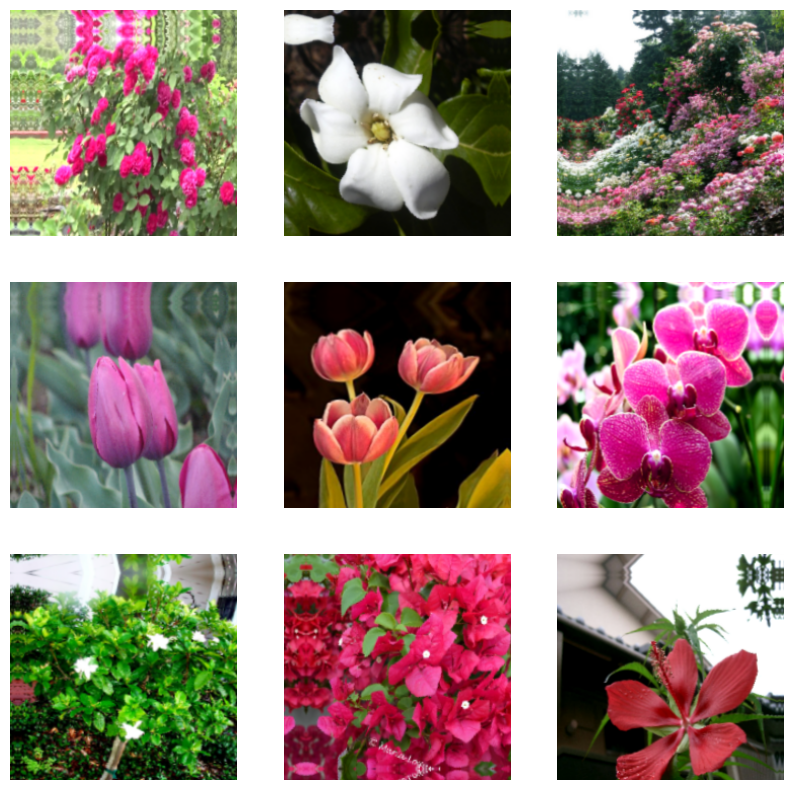

In [3]:
# using augmentation pipeline with 5 total augmentations
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

# augmenting training data only
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

# visualizing augmentations
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
plt.show()

In [4]:
# making a ResNet101v2 model creating function
def make_resnet101v2_model(input_shape, num_classes):
    backbone = keras.applications.ResNet101V2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False  # freeze backbone

    inputs = layers.Input(input_shape)
    x = keras.applications.resnet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling2D()(x)

    units = 1 if num_classes == 2 else num_classes
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="resnet101v2_transfer")

image_size = (224, 224)
num_classes = 10

In [5]:
# creating the model
model_resnet101v2 = make_resnet101v2_model(input_shape=image_size + (3,), num_classes=num_classes)

In [6]:
# training model
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model_resnet101v2.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

history = model_resnet101v2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 616ms/step - acc: 0.2019 - loss: 2.5406 - val_acc: 0.5479 - val_loss: 1.4052
Epoch 2/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 635ms/step - acc: 0.5498 - loss: 1.4124 - val_acc: 0.8356 - val_loss: 0.9255
Epoch 3/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 657ms/step - acc: 0.7154 - loss: 0.9100 - val_acc: 0.8562 - val_loss: 0.7263
Epoch 4/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 672ms/step - acc: 0.8289 - loss: 0.6554 - val_acc: 0.8630 - val_loss: 0.6224
Epoch 5/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 698ms/step - acc: 0.8462 - loss: 0.5446 - val_acc: 0.8904 - val_loss: 0.5451
Epoch 6/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 50s 848ms/step - acc: 0.8720 - loss: 0.4611 - val_acc: 0.8836 - val_loss: 0.4949
Epoch 7/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 936ms/step - acc: 0.8926 - loss: 0.3721 - val_acc: 0.8767 - val_loss: 0.4618
Epoch 8/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 56s 955ms/step - acc: 0.9286 - loss: 0.3062 - val_acc: 0.8767 - val_loss: 0.4350


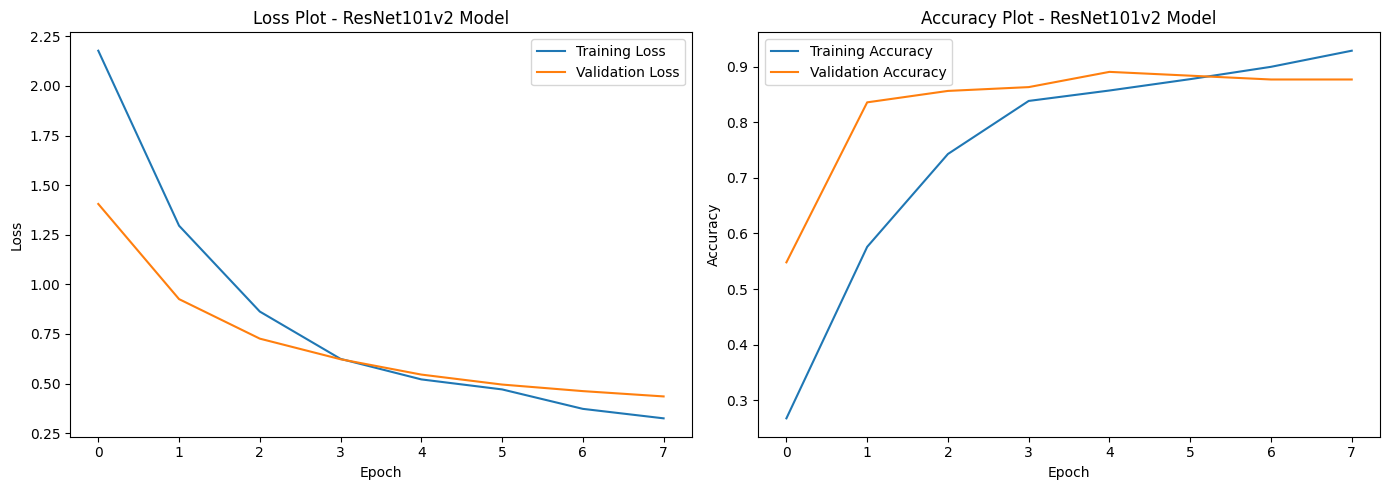

In [7]:
# plotting loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

axs[0].plot(history.history["loss"], label="Training Loss")
axs[0].plot(history.history["val_loss"], label="Validation Loss")
axs[0].set_title("Loss Plot - ResNet101v2 Model")
axs[0].legend()
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].plot(history.history["acc"], label="Training Accuracy")
axs[1].plot(history.history["val_acc"], label="Validation Accuracy")
axs[1].set_title("Accuracy Plot - ResNet101v2 Model")
axs[1].legend()
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [8]:
# saving model
model_resnet101v2.save("flowers_classifier_resnet101v2.keras")